# Imports

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Preprocessing

In [10]:
df = pd.read_csv("logs.csv", sep=",")

df["Door_wide_open"] = df["Door"]=="open"
df["Door_ajar"] = df["Door"]=="ajar"
df.drop(columns=["Door"], axis=1, inplace=True)
df["t"] = pd.to_datetime(df["t"], format="mixed")

df["Alarm level"] = df["Alarm level"].map(lambda x: int(x[:1]))
df

,t,Dist,Iteration time,Counter_open,Counter_ajar,Alarm level,Door_wide_open,Door_ajar
0,2025-10-19 21:55:08.886219,35.68,1.12,1,1,0,False,True
1,2025-10-19 21:55:10.010044,36.07,1.12,2,2,0,False,True
2,2025-10-19 21:55:11.134011,35.83,1.12,3,3,0,False,True
3,2025-10-19 21:55:12.458006,35.77,1.12,4,4,3,False,True
4,2025-10-19 21:55:13.781939,35.69,1.12,5,5,3,False,True
5,2025-10-19 21:55:15.206052,31.88,1.12,6,6,3,False,True
6,2025-10-19 21:56:16.740353,34.23,1.12,1,1,0,False,True
7,2025-10-19 21:56:17.863939,83.13,1.12,2,0,0,True,False
8,2025-10-19 21:56:19.087866,97.96,1.12,3,0,0,True,False
9,2025-10-19 21:56:20.211134,73.10,1.12,4,0,0,True,False


In [3]:
#filtered_df = df.loc[(df['t'] >= '2025-09-18') & (df['t'] < '2025-09-23')]

# General statistics
## openings per day

In [9]:
tmp = df[["t", "Door_wide_open"]].copy()
idx = np.where(
    np.all(np.lib.stride_tricks.sliding_window_view(tmp["Door_wide_open"].copy(), 2) == [0,1], axis=1)
)[0] + 1
beginnings = np.zeros((len(tmp)))
beginnings[idx] = 1
tmp["Door_wide_open_start"] = beginnings
tmp
# how to consider time break???

,t,Door_wide_open,Door_wide_open_start
0,2025-10-19 21:55:08.886219,False,0.0
1,2025-10-19 21:55:10.010044,False,0.0
2,2025-10-19 21:55:11.134011,False,0.0
3,2025-10-19 21:55:12.458006,False,0.0
4,2025-10-19 21:55:13.781939,False,0.0
5,2025-10-19 21:55:15.206052,False,0.0
6,2025-10-19 21:56:16.740353,False,0.0
7,2025-10-19 21:56:17.863939,True,1.0
8,2025-10-19 21:56:19.087866,True,0.0
9,2025-10-19 21:56:20.211134,True,0.0


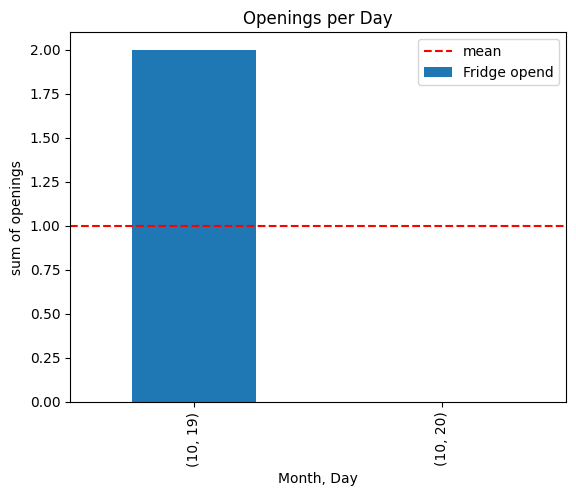

In [8]:
tmp["t"] = tmp["t"].apply(lambda t: (t.month, t.day))
tmp_grouped = tmp.groupby("t")["Door_wide_open_start"].sum()

tmp_grouped.plot(kind="bar", label="Fridge opend")
plt.xlabel("Month, Day")
plt.ylabel("sum of openings")
plt.title("Openings per Day")
plt.axhline(tmp_grouped.mean(), linestyle="--", color="r", label="mean")
plt.legend()
plt.show()

## ajar door

In [ ]:
ajar_df = df[["t" ,"Door_ajar", "Alarm level"]].copy()
#ajar_df["Door"] = ajar_df["Door"].apply(lambda x: 1 if x == "ajar" else 0) # make numeric for processing

ajar_df["Door_ajar"] = np.where(ajar_df["Door_ajar"] & (ajar_df["Alarm level"] > 2), 1, 0) # filter for slightly open door and alarm level (repeated measurements)

# find beginnings (find all [0,1] occurrences)
idx = np.where(
    np.all(np.lib.stride_tricks.sliding_window_view(ajar_df["Door_ajar"].copy(), 2) == [0,1], axis=1)
)[0] + 1 # +1 so that we don't find the 0s

beginnings = np.zeros((len(ajar_df)))
beginnings[idx] = 1
ajar_df["Door_ajar_start"] = beginnings

### Plot

In [ ]:
plt.figure(figsize=(10,10))
ax = ajar_df.plot("t", "Door_ajar_start")
plt.title("Alarm triggered because door was slightly left open")
plt.ylabel("alarm triggered")
plt.xlabel("time")
ax.get_legend().remove()
plt.yticks(ticks=[0,1], labels=["NO", "YES"])
plt.show()
print("Total times alarm was triggered because door was slightly left open:", int(np.sum(beginnings)))

In [ ]:
tmp = ajar_df.copy()
tmp["t"] = ajar_df["t"].apply(lambda t: (t.month, t.day))
tmp = tmp.groupby("t")["Door_ajar_start"].sum()

tmp.plot(kind="bar", label="Alarm triggered")
plt.xlabel("Month, Day")
plt.ylabel("sum of occurrences")
plt.title("Occurrences per Day")
plt.axhline(tmp.mean(), linestyle="--", color="r", label="mean")
plt.legend()
plt.show()

## Plot open door

In [ ]:
# plot open door
open_df = df[["t" ,"Door_open", "Alarm level"]].copy()
open_df["Door_open"] = open_df["Door_open"].apply(lambda x: 1 if x == "open" else 0) #todo
open_df["door_num"] = np.where((open_df["Door_open"] == 1) & (tmp["Alarm level"] > 0), 1, 0)
open_df.plot("t", "door_num")

In [ ]:
a = np.array([1, 2, 3, 2, 3, 4, 5])
b = np.array([2, 3])

idx = np.where(
    np.all(np.lib.stride_tricks.sliding_window_view(a, len(b)) == b, axis=1)
)[0]
print(idx)